# SETUP

In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score
)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")

# Reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()


🚀 Using device: cuda


# DATASET & DATALOADER

In [2]:
TRAIN_DIR = '/kaggle/input/processed-dataset-final/train'
VAL_DIR   = '/kaggle/input/processed-dataset-final/validation'

BATCH_SIZE = 32
NUM_CLASSES = 7

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

train_ds = ImageFolder(TRAIN_DIR, transform=transform)
val_ds   = ImageFolder(VAL_DIR,   transform=transform)

train_loader = DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
val_loader = DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

class_names = train_ds.classes
val_size = len(val_ds)

print("📂 Classes:", class_names)


📂 Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


# MODEL DEFINITIONS

In [3]:
class CNNBaseline(nn.Module):
    def __init__(self, num_classes=7):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)
        return self.classifier(x)

def build_resnet18(num_classes=7):
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

model_cnn = CNNBaseline(NUM_CLASSES).to(device)
model_resnet = build_resnet18(NUM_CLASSES).to(device)

criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 233MB/s]


# TRAIN / VALIDATION ENGINE

In [4]:
def train_one_epoch(model, loader, criterion, optimizer, epoch_idx):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    pbar = tqdm(loader, desc=f"Train Ep {epoch_idx+1}")
    for inputs, labels in pbar:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels)

        pbar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc  = running_corrects.double() / len(loader.dataset)
    return epoch_loss, epoch_acc.item()


def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(1)

            running_loss += loss.item()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(loader), correct / total


# TRAIN FUNCTION

In [5]:
def run_epoch(model, dataloader, criterion, epoch_idx, dataset_size, model_name="Model"):
    print(f"\n🔍 Evaluating {model_name}")
    print(f"{'Epoch':^7} | {'Phase':^7} | {'Loss':^10} | {'Acc':^10}")
    print("-" * 50)

    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        pbar = tqdm(dataloader, desc=f"Eval Ep {epoch_idx+1}", leave=False)
        for inputs, labels in pbar:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

            pbar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size

    print(f"{epoch_idx+1:^7} | {'val':^7} | {epoch_loss:^10.4f} | {epoch_acc:^10.4f}")

    return epoch_acc.item(), epoch_loss

In [6]:
def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4, model_name="Model"):
    model = model.to(device)
    print(f"📌 {model_name} running on:", next(model.parameters()).device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        print(f"\n📘 Epoch [{epoch+1}/{epochs}]")

        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, epoch
        )

        run_epoch(
            model, val_loader, criterion,
            epoch_idx=epoch,
            dataset_size=len(val_loader.dataset),
            model_name=model_name
        )

    return model

# RUN TESTING

In [7]:
# ===== CNN =====
cnn_model = CNNBaseline().to(device)
cnn_model = train_model(
    cnn_model,
    train_loader,
    val_loader,
    epochs=5,
    model_name="CNN Baseline"
)

# ===== RESNET =====
resnet_model = build_resnet18().to(device)
resnet_model = train_model(
    resnet_model,
    train_loader,
    val_loader,
    epochs=5,
    model_name="ResNet18"
)

📌 CNN Baseline running on: cuda:0

📘 Epoch [1/5]


Train Ep 1: 100%|██████████| 1049/1049 [02:08<00:00,  8.17it/s, loss=1.6335]



🔍 Evaluating CNN Baseline
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


   1    |   val   |   1.4191   |   0.4611  

📘 Epoch [2/5]


Train Ep 2: 100%|██████████| 1049/1049 [01:05<00:00, 16.13it/s, loss=0.9987]



🔍 Evaluating CNN Baseline
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


   2    |   val   |   1.3303   |   0.4979  

📘 Epoch [3/5]


Train Ep 3: 100%|██████████| 1049/1049 [01:04<00:00, 16.30it/s, loss=0.7651]



🔍 Evaluating CNN Baseline
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


   3    |   val   |   1.2926   |   0.5085  

📘 Epoch [4/5]


Train Ep 4: 100%|██████████| 1049/1049 [01:05<00:00, 15.96it/s, loss=0.8794]



🔍 Evaluating CNN Baseline
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


   4    |   val   |   1.3207   |   0.5214  

📘 Epoch [5/5]


Train Ep 5: 100%|██████████| 1049/1049 [01:04<00:00, 16.26it/s, loss=0.7071]



🔍 Evaluating CNN Baseline
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


   5    |   val   |   1.3844   |   0.5215  
📌 ResNet18 running on: cuda:0

📘 Epoch [1/5]


Train Ep 1: 100%|██████████| 1049/1049 [01:17<00:00, 13.48it/s, loss=0.9909]



🔍 Evaluating ResNet18
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


   1    |   val   |   0.9741   |   0.6441  

📘 Epoch [2/5]


Train Ep 2: 100%|██████████| 1049/1049 [01:17<00:00, 13.50it/s, loss=0.7327]



🔍 Evaluating ResNet18
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


   2    |   val   |   0.9522   |   0.6654  

📘 Epoch [3/5]


Train Ep 3: 100%|██████████| 1049/1049 [01:17<00:00, 13.49it/s, loss=0.4600]



🔍 Evaluating ResNet18
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


   3    |   val   |   1.1016   |   0.6526  

📘 Epoch [4/5]


Train Ep 4: 100%|██████████| 1049/1049 [01:17<00:00, 13.49it/s, loss=0.0557]



🔍 Evaluating ResNet18
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


   4    |   val   |   1.3303   |   0.6466  

📘 Epoch [5/5]


Train Ep 5: 100%|██████████| 1049/1049 [01:17<00:00, 13.46it/s, loss=0.2697]



🔍 Evaluating ResNet18
 Epoch  |  Phase  |    Loss    |    Acc    
--------------------------------------------------


   5    |   val   |   1.4961   |   0.6333  


# Comparison & Visualization

In [8]:
def evaluate_model_detailed(model, dataloader, class_names, model_name="Model"):
    model.eval()
    y_true, y_pred = [], []

    print("\n" + "="*60)
    print(f"🔍 DETAILED EVALUATION — {model_name}")
    print("="*60)

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f"Eval {model_name}", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # --- Classification Report ---
    print("\n📊 CLASSIFICATION REPORT")
    print(classification_report(
        y_true, y_pred,
        target_names=class_names,
        digits=4
    ))

    # --- F1 Score ---
    f1_weighted = f1_score(y_true, y_pred, average="weighted")
    print(f"⭐ Weighted F1-score: {f1_weighted:.4f}")

    return np.array(y_true), np.array(y_pred), f1_weighted

y_true_cnn, y_pred_cnn, f1_cnn = evaluate_model_detailed(
    cnn_model,   # ✅ MODEL ĐÃ TRAIN
    val_loader,
    class_names,
    model_name="CNN Baseline"
)

y_true_res, y_pred_res, f1_res = evaluate_model_detailed(
    resnet_model,  # ✅ MODEL ĐÃ TRAIN
    val_loader,
    class_names,
    model_name="ResNet18"
)


🔍 DETAILED EVALUATION — CNN Baseline



📊 CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry     0.4444    0.3625    0.3993       960
     disgust     0.4766    0.5495    0.5105       111
        fear     0.3976    0.3625    0.3792      1018
       happy     0.6351    0.7726    0.6972      1825
     neutral     0.5201    0.3832    0.4413      1216
         sad     0.3881    0.4126    0.4000      1139
    surprise     0.6233    0.7039    0.6612       797

    accuracy                         0.5215      7066
   macro avg     0.4979    0.5067    0.4984      7066
weighted avg     0.5116    0.5215    0.5120      7066

⭐ Weighted F1-score: 0.5120

🔍 DETAILED EVALUATION — ResNet18



📊 CLASSIFICATION REPORT
              precision    recall  f1-score   support

       angry     0.6000    0.5000    0.5455       960
     disgust     0.6981    0.6667    0.6820       111
        fear     0.4586    0.5108    0.4833      1018
       happy     0.7780    0.9025    0.8356      1825
     neutral     0.6828    0.4408    0.5357      1216
         sad     0.4661    0.5610    0.5092      1139
    surprise     0.7689    0.7265    0.7471       797

    accuracy                         0.6333      7066
   macro avg     0.6361    0.6155    0.6198      7066
weighted avg     0.6389    0.6333    0.6288      7066

⭐ Weighted F1-score: 0.6288


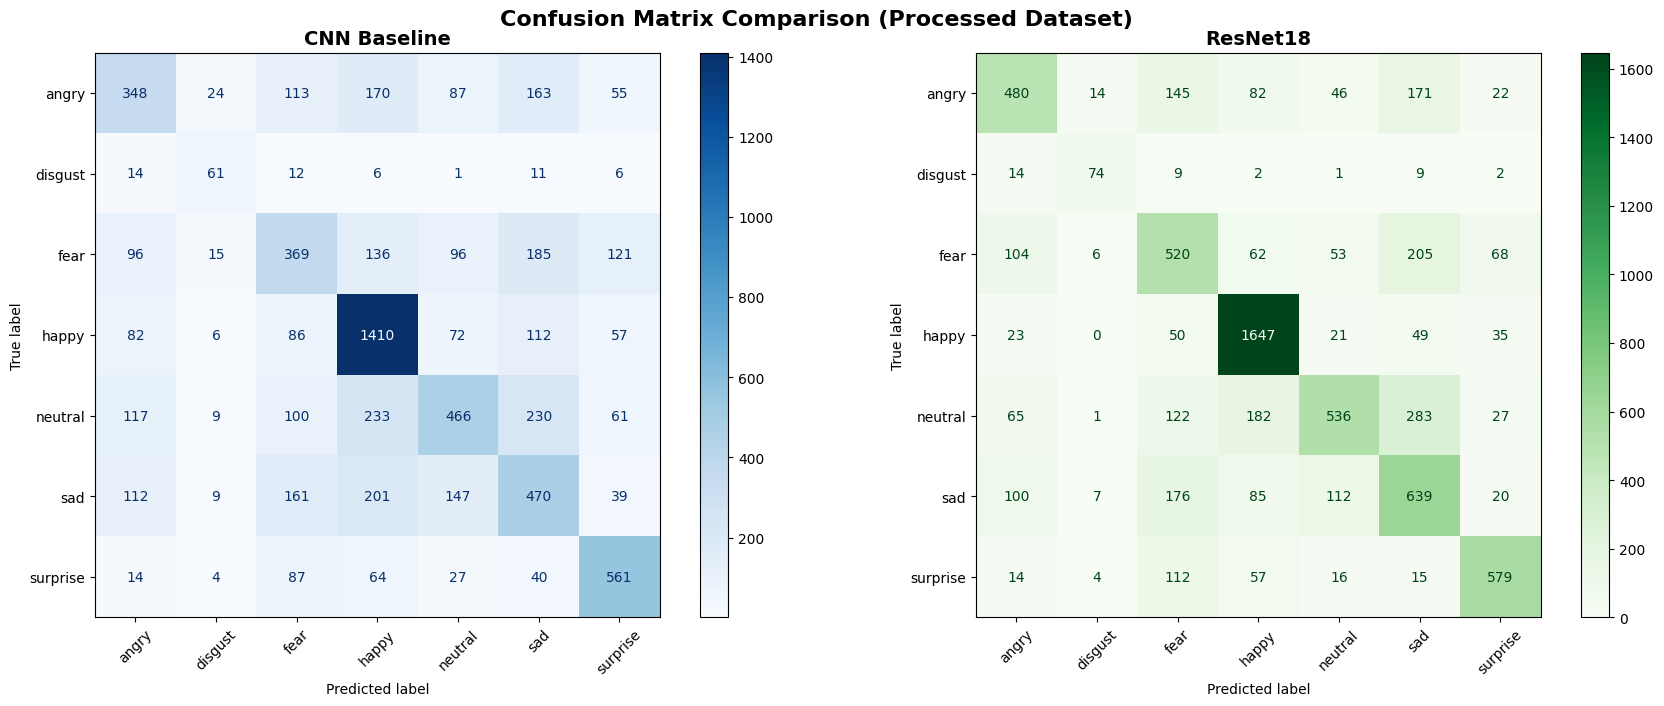

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- CNN ---
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
disp_cnn = ConfusionMatrixDisplay(cm_cnn, display_labels=class_names)
disp_cnn.plot(ax=axes[0], cmap="Blues", values_format='d')
axes[0].set_title("CNN Baseline", fontsize=14, fontweight="bold")
axes[0].tick_params(axis='x', rotation=45)

# --- ResNet ---
cm_res = confusion_matrix(y_true_res, y_pred_res)
disp_res = ConfusionMatrixDisplay(cm_res, display_labels=class_names)
disp_res.plot(ax=axes[1], cmap="Greens", values_format='d')
axes[1].set_title("ResNet18", fontsize=14, fontweight="bold")
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle("Confusion Matrix Comparison (Processed Dataset)", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

In [10]:
print("\n" + "="*60)
print("📌 FINAL COMPARISON SUMMARY")
print("="*60)
print(f"CNN Baseline  - Weighted F1: {f1_cnn:.4f}")
print(f"ResNet18     - Weighted F1: {f1_res:.4f}")

if f1_res > f1_cnn:
    print("✅ ResNet18 outperforms CNN Baseline on the processed dataset.")
else:
    print("⚠️ CNN Baseline performs comparably or better than ResNet18.")


📌 FINAL COMPARISON SUMMARY
CNN Baseline  - Weighted F1: 0.5120
ResNet18     - Weighted F1: 0.6288
✅ ResNet18 outperforms CNN Baseline on the processed dataset.
